#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
!pip install optuna -q
!pip install optuna-integration -q
!pip install catboost -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

import optuna
from optuna import trial
from optuna import distributions
from optuna.integration import OptunaSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# df = pd.read_csv('/content/drive/MyDrive/csv/taxi.csv', index_col=[0], parse_dates=[0])
# df.sort_index(inplace=True)

Данные представленны в виде временного ряда:

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице 26496 наблюдений на диапазоне времени '2018-03-01 00:00:00' - '2018-08-31 23:50:00', кол-во заказов представленно в int64 типе данных

### Пропуски, дубликаты

In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

In [ ]:
df.index.duplicated().sum()

0

Пропусков и явных дубликатов в данных нет

### Ресемплирование

Проведем ресемплирование ряда по одному часу

In [ ]:
df = df.resample('1H').sum()

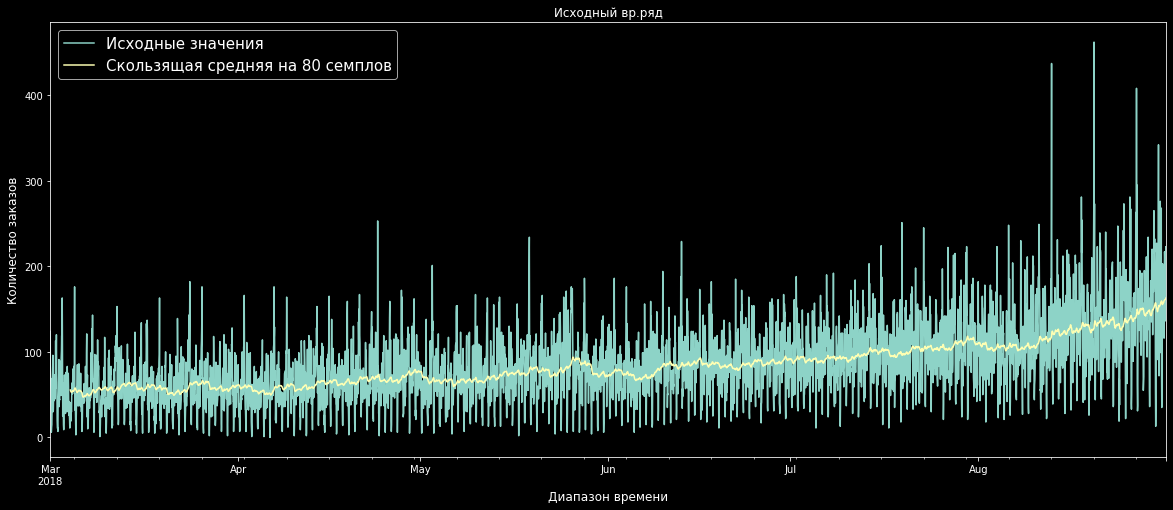

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Исходный вр.ряд')
df.plot(ax=plt.gca())
df.shift().rolling(80).mean().plot(ax=plt.gca())
plt.gca().legend_.remove()
_ = plt.legend(['Исходные значения', 'Скользящая средняя на 80 семплов'], fontsize=15)
_ = plt.xlabel('Диапазон времени', fontsize=12)
_ = plt.ylabel('Количество заказов', fontsize=12)

На первый взгляд ряд выглядит слегка не стационарно, виднеются повышения ср.значения и дисперсии со временем

## Анализ

In [ ]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Значения ряда варьируются от 0 до 462, в среднем 84.4, стандартное отклонение - 45

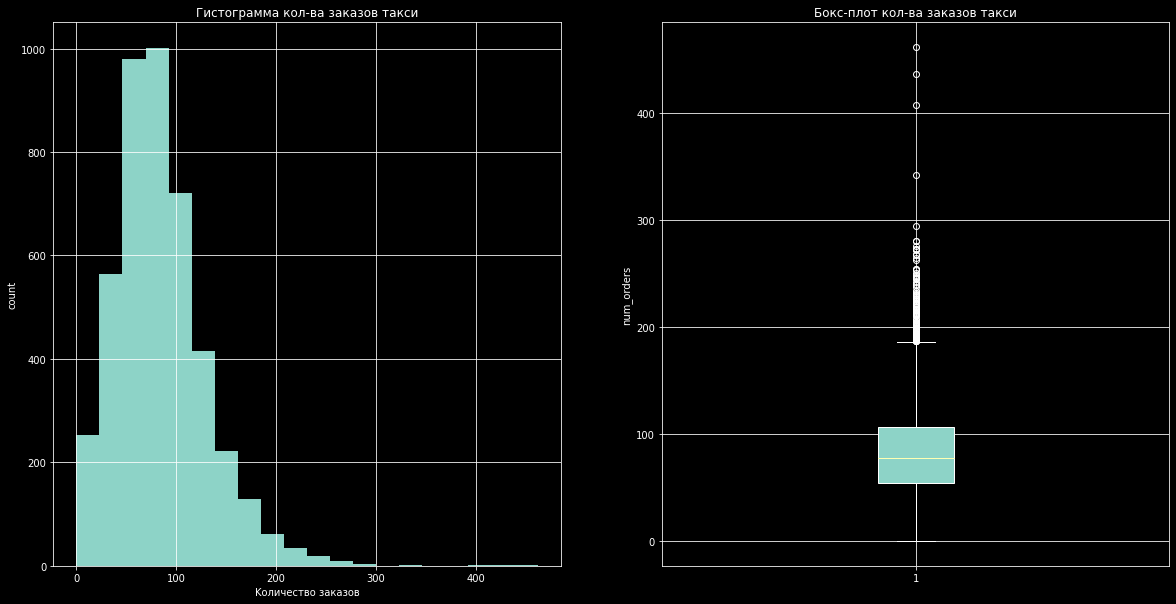

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].hist(df['num_orders'], bins=20)
ax[0].grid(True)
ax[0].set_title('Гистограмма кол-ва заказов такси')
ax[0].set_xlabel('Kоличество заказов')
ax[0].set_ylabel('count')

ax[1].boxplot(df['num_orders'], patch_artist=True)
ax[1].set_ylabel('num_orders')
ax[1].set_title('Бокс-плот кол-ва заказов такси')
ax[1].grid(True)

plt.show()

Напоминает нормальное распределение со 'скосом' к левому краю, значения находящиеся в правой части распределения слегка выбиваются из общей массы

In [ ]:
df['rolling_mean'] = df['num_orders'].shift().rolling(80).mean()

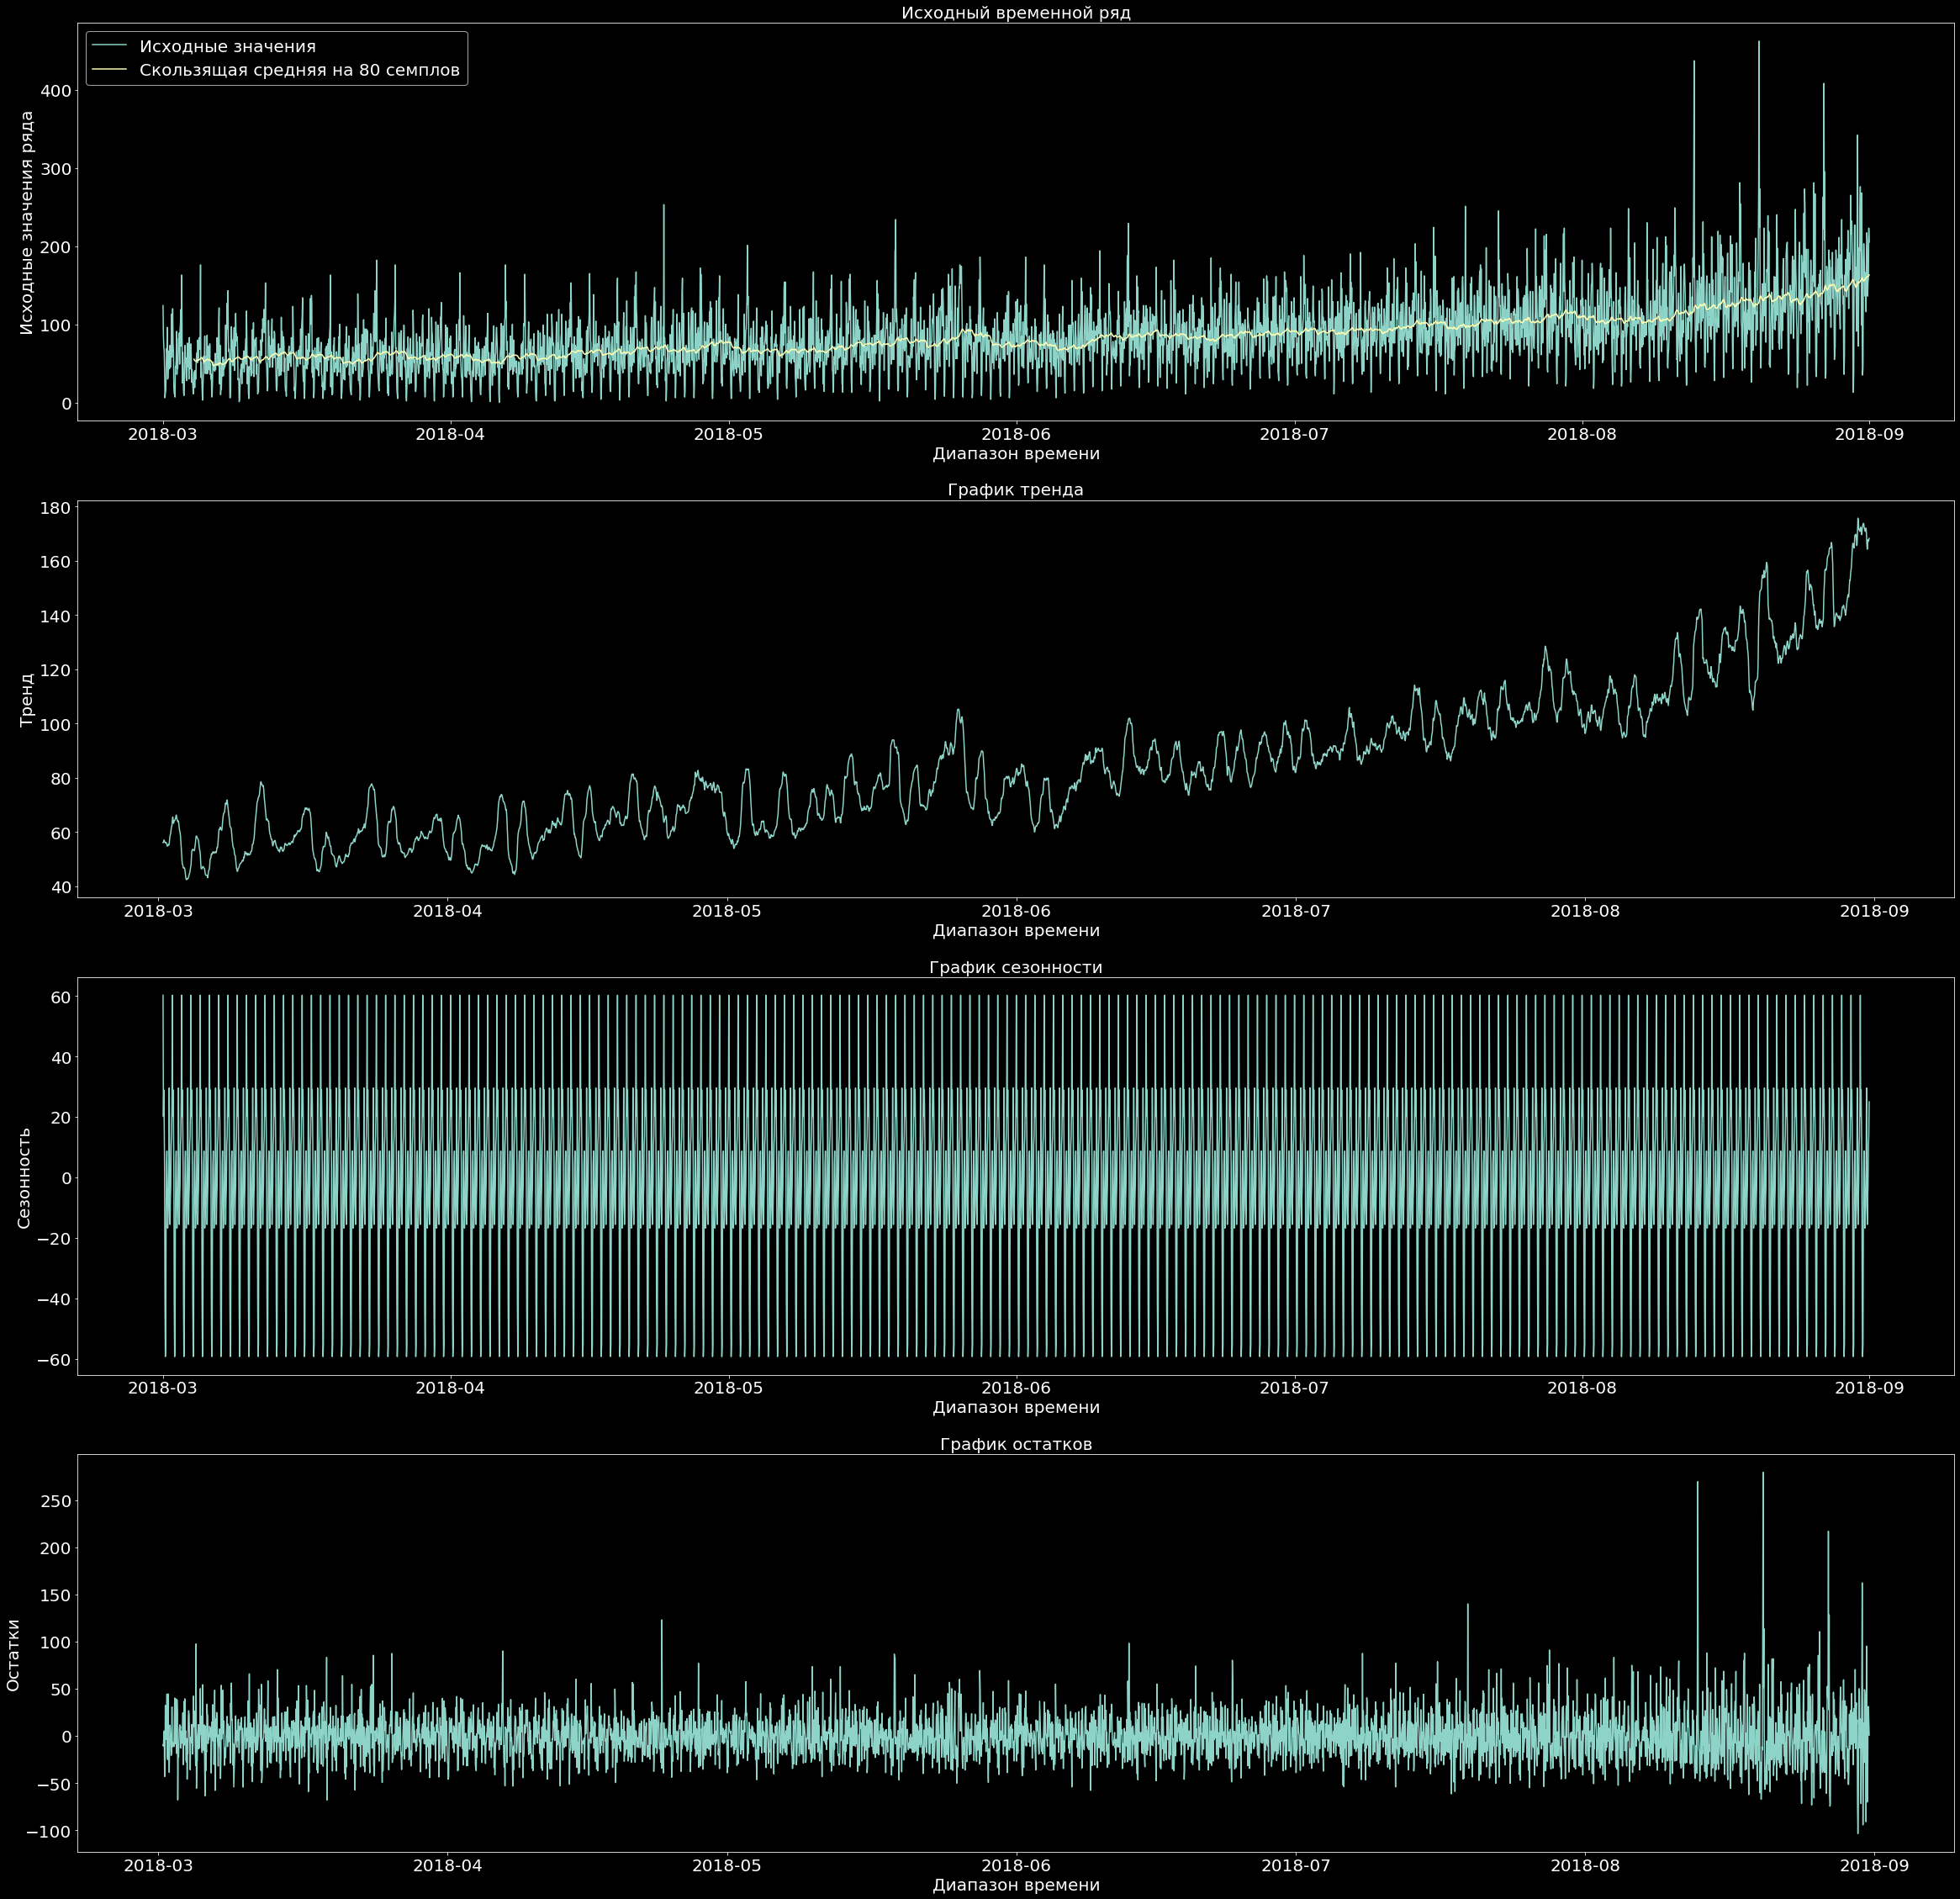

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(40, 40))

decomposed = seasonal_decompose(df['num_orders'])

ax[0].plot(df.index, decomposed.observed)
ax[0].plot(df.index, df['rolling_mean'])
ax[0].set_ylabel('Исходные значения ряда', fontsize=20)

ax[1].plot(df.index, decomposed.trend)
ax[1].set_ylabel('Тренд', fontsize=20)

ax[2].plot(df.index, decomposed.seasonal)
ax[2].set_ylabel('Сезонность', fontsize=20)

ax[3].plot(df.index, decomposed.resid)
ax[3].set_ylabel('Остатки', fontsize=20)

ax[0].tick_params(axis='y', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[2].tick_params(axis='y', labelsize=20)
ax[3].tick_params(axis='y', labelsize=20)

ax[0].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='x', labelsize=20)
ax[2].tick_params(axis='x', labelsize=20)
ax[3].tick_params(axis='x', labelsize=20)

ax[0].legend(['Исходные значения', 'Скользящая средняя на 80 семплов'], fontsize=20)
ax[0].set_title('Исходный временной ряд', fontsize=20)
ax[1].set_title('График тренда', fontsize=20)
ax[2].set_title('График сезонности', fontsize=20)
ax[3].set_title('График остатков', fontsize=20)
ax[0].set_xlabel('Диапазон времени', fontsize=20)
ax[1].set_xlabel('Диапазон времени', fontsize=20)
ax[2].set_xlabel('Диапазон времени', fontsize=20)
ax[3].set_xlabel('Диапазон времени', fontsize=20)


plt.show.legend = False

Тренд ряда восходящий

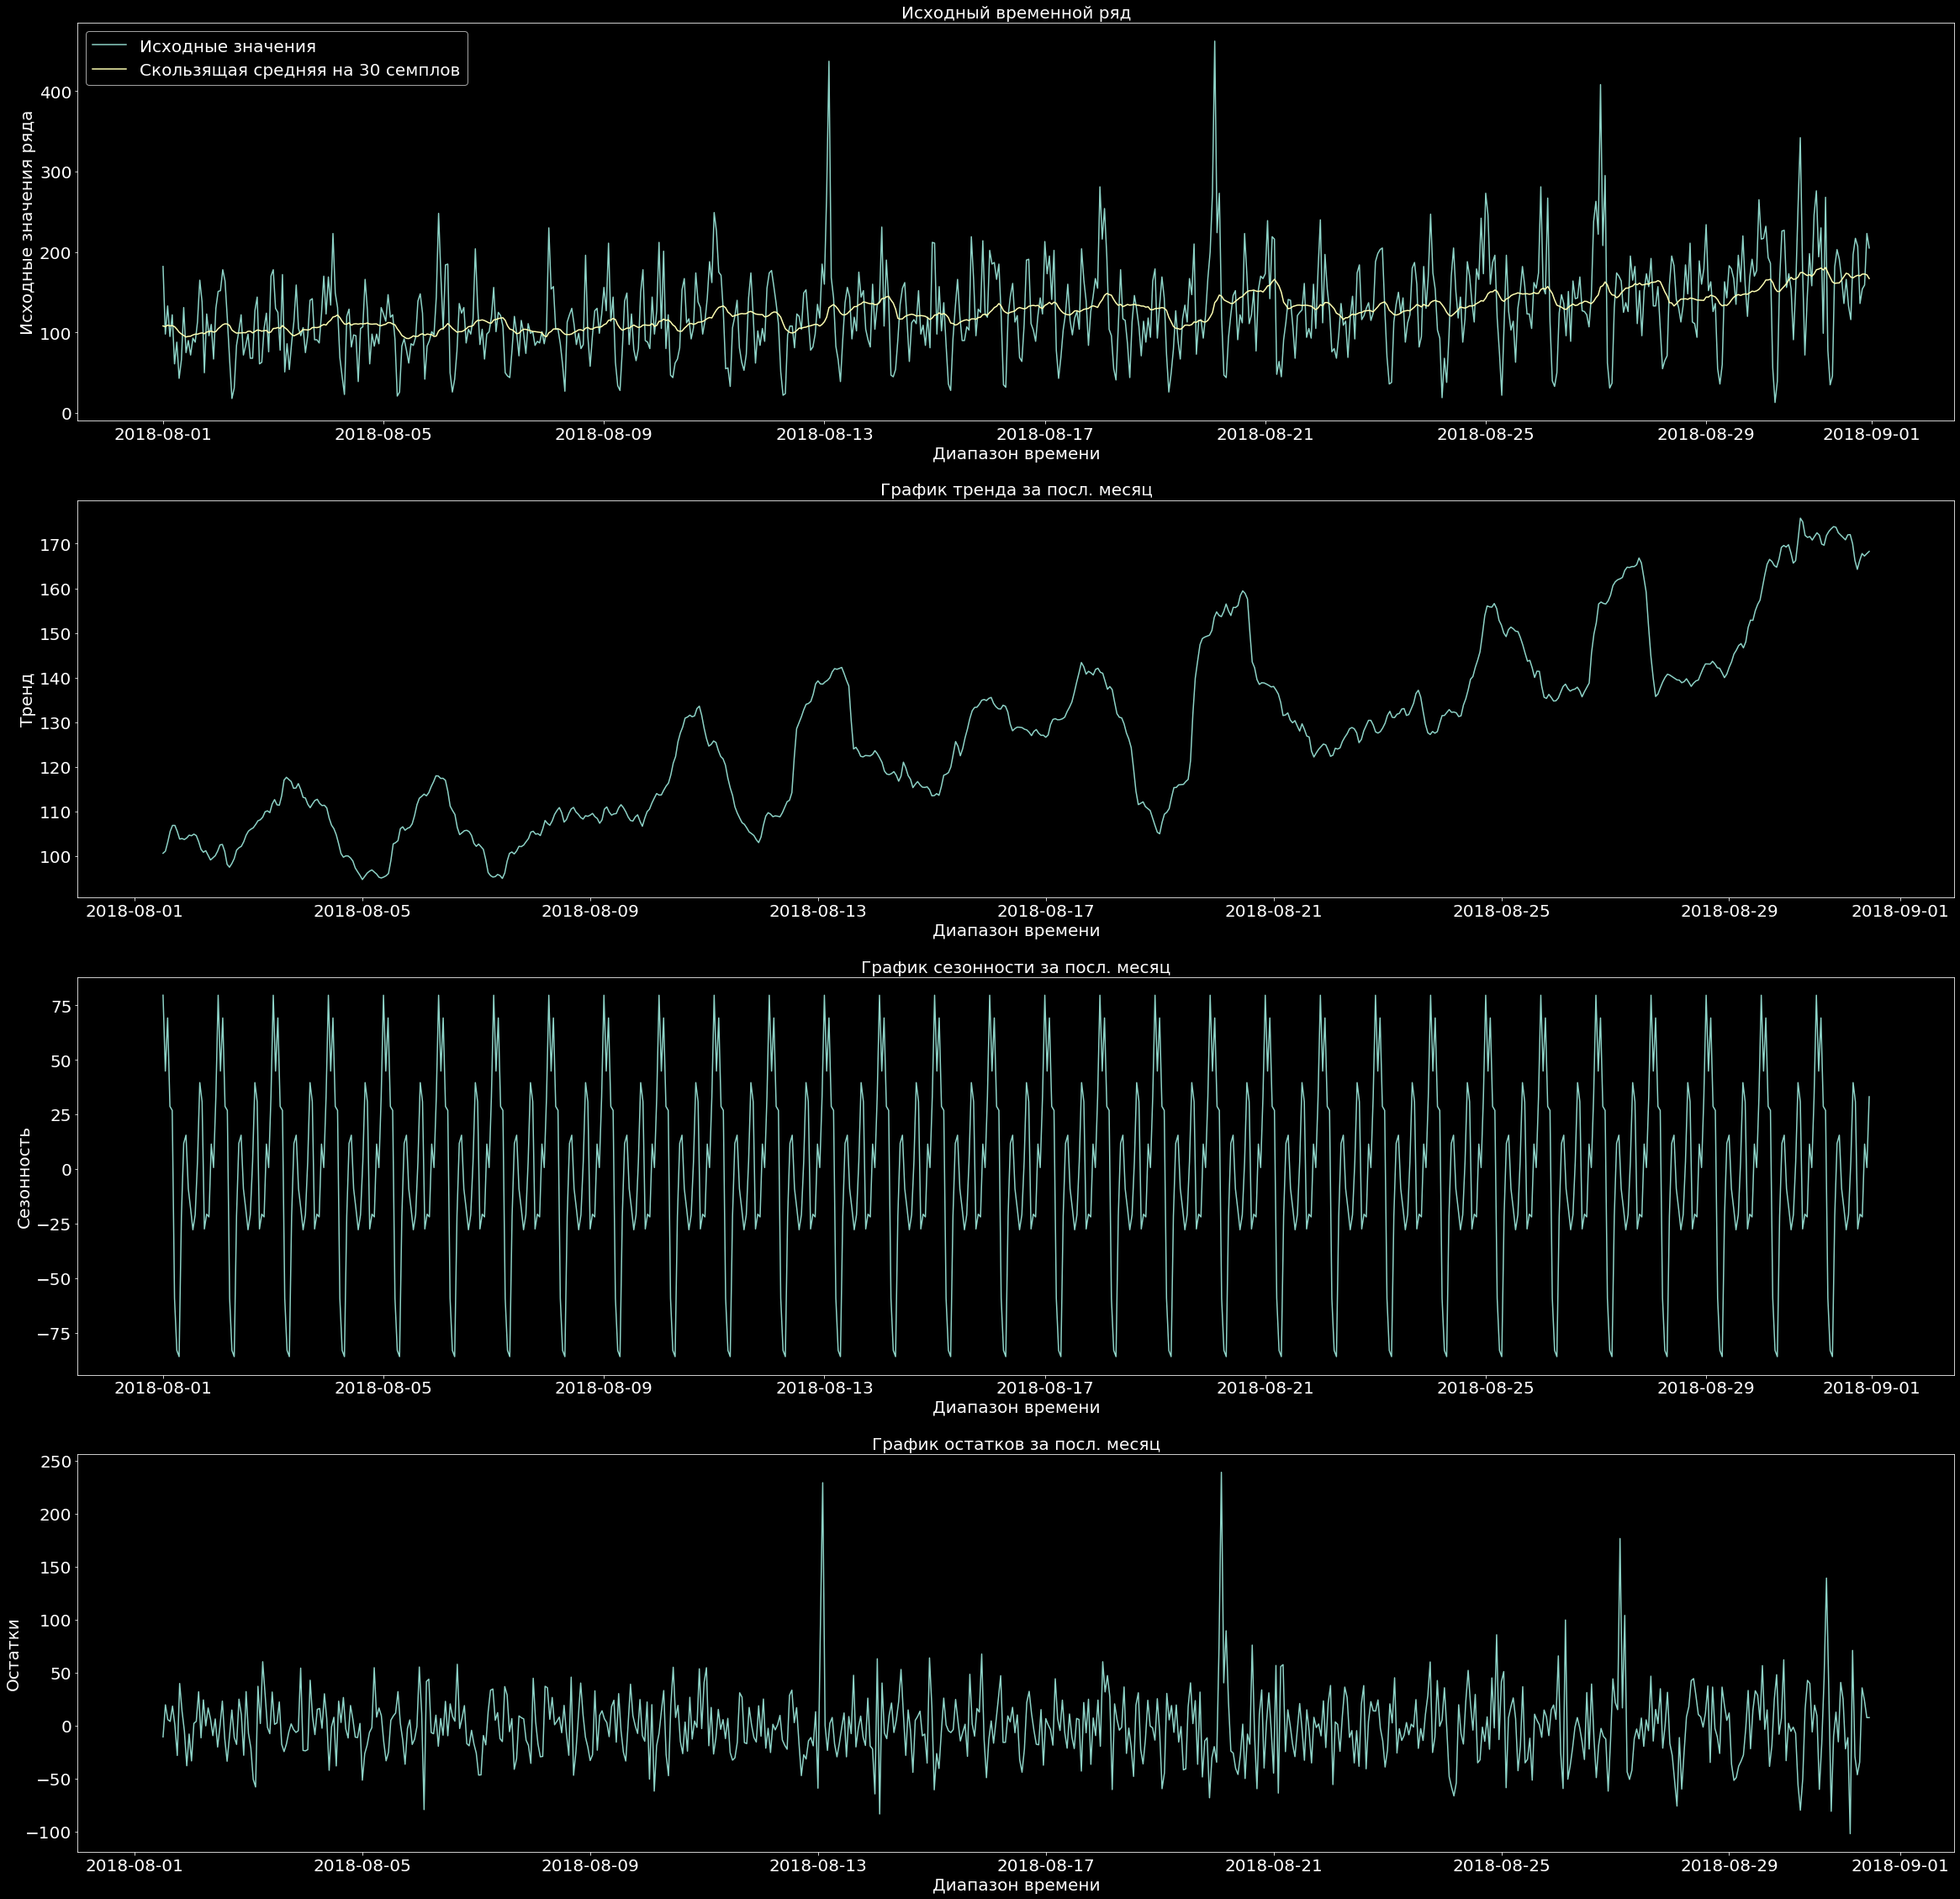

In [ ]:
df['rolling_mean'] = df['num_orders'].rolling(30).mean()

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(40, 40))

decomposed = seasonal_decompose(df['2018-08':'2018-08']['num_orders'])

ax[0].plot(df['2018-08':'2018-08'].index, decomposed.observed)
ax[0].plot(df['2018-08':'2018-08'].index, df['2018-08':'2018-08']['rolling_mean'])
ax[0].set_ylabel('Исходные значения ряда', fontsize=20)

ax[1].plot(df['2018-08':'2018-08'].index, decomposed.trend)
ax[1].set_ylabel('Тренд', fontsize=20)

ax[2].plot(df['2018-08':'2018-08'].index, decomposed.seasonal)
ax[2].set_ylabel('Сезонность', fontsize=20)

ax[3].plot(df['2018-08':'2018-08'].index, decomposed.resid)
ax[3].set_ylabel('Остатки', fontsize=20)

ax[0].tick_params(axis='y', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[2].tick_params(axis='y', labelsize=20)
ax[3].tick_params(axis='y', labelsize=20)

ax[0].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='x', labelsize=20)
ax[2].tick_params(axis='x', labelsize=20)
ax[3].tick_params(axis='x', labelsize=20)

ax[0].legend(['Исходные значения', 'Скользящая средняя на 30 семплов'], fontsize=20)
ax[0].set_title('Исходный временной ряд', fontsize=20)
ax[1].set_title('График тренда за посл. месяц', fontsize=20)
ax[2].set_title('График сезонности за посл. месяц', fontsize=20)
ax[3].set_title('График остатков за посл. месяц', fontsize=20)
ax[0].set_xlabel('Диапазон времени', fontsize=20)
ax[1].set_xlabel('Диапазон времени', fontsize=20)
ax[2].set_xlabel('Диапазон времени', fontsize=20)
ax[3].set_xlabel('Диапазон времени', fontsize=20)

plt.show.legend = False

При приближении ряда, моментами стали более остро видны выбивающиеся значения, которые циклируются каждую неделю (это понедельник)

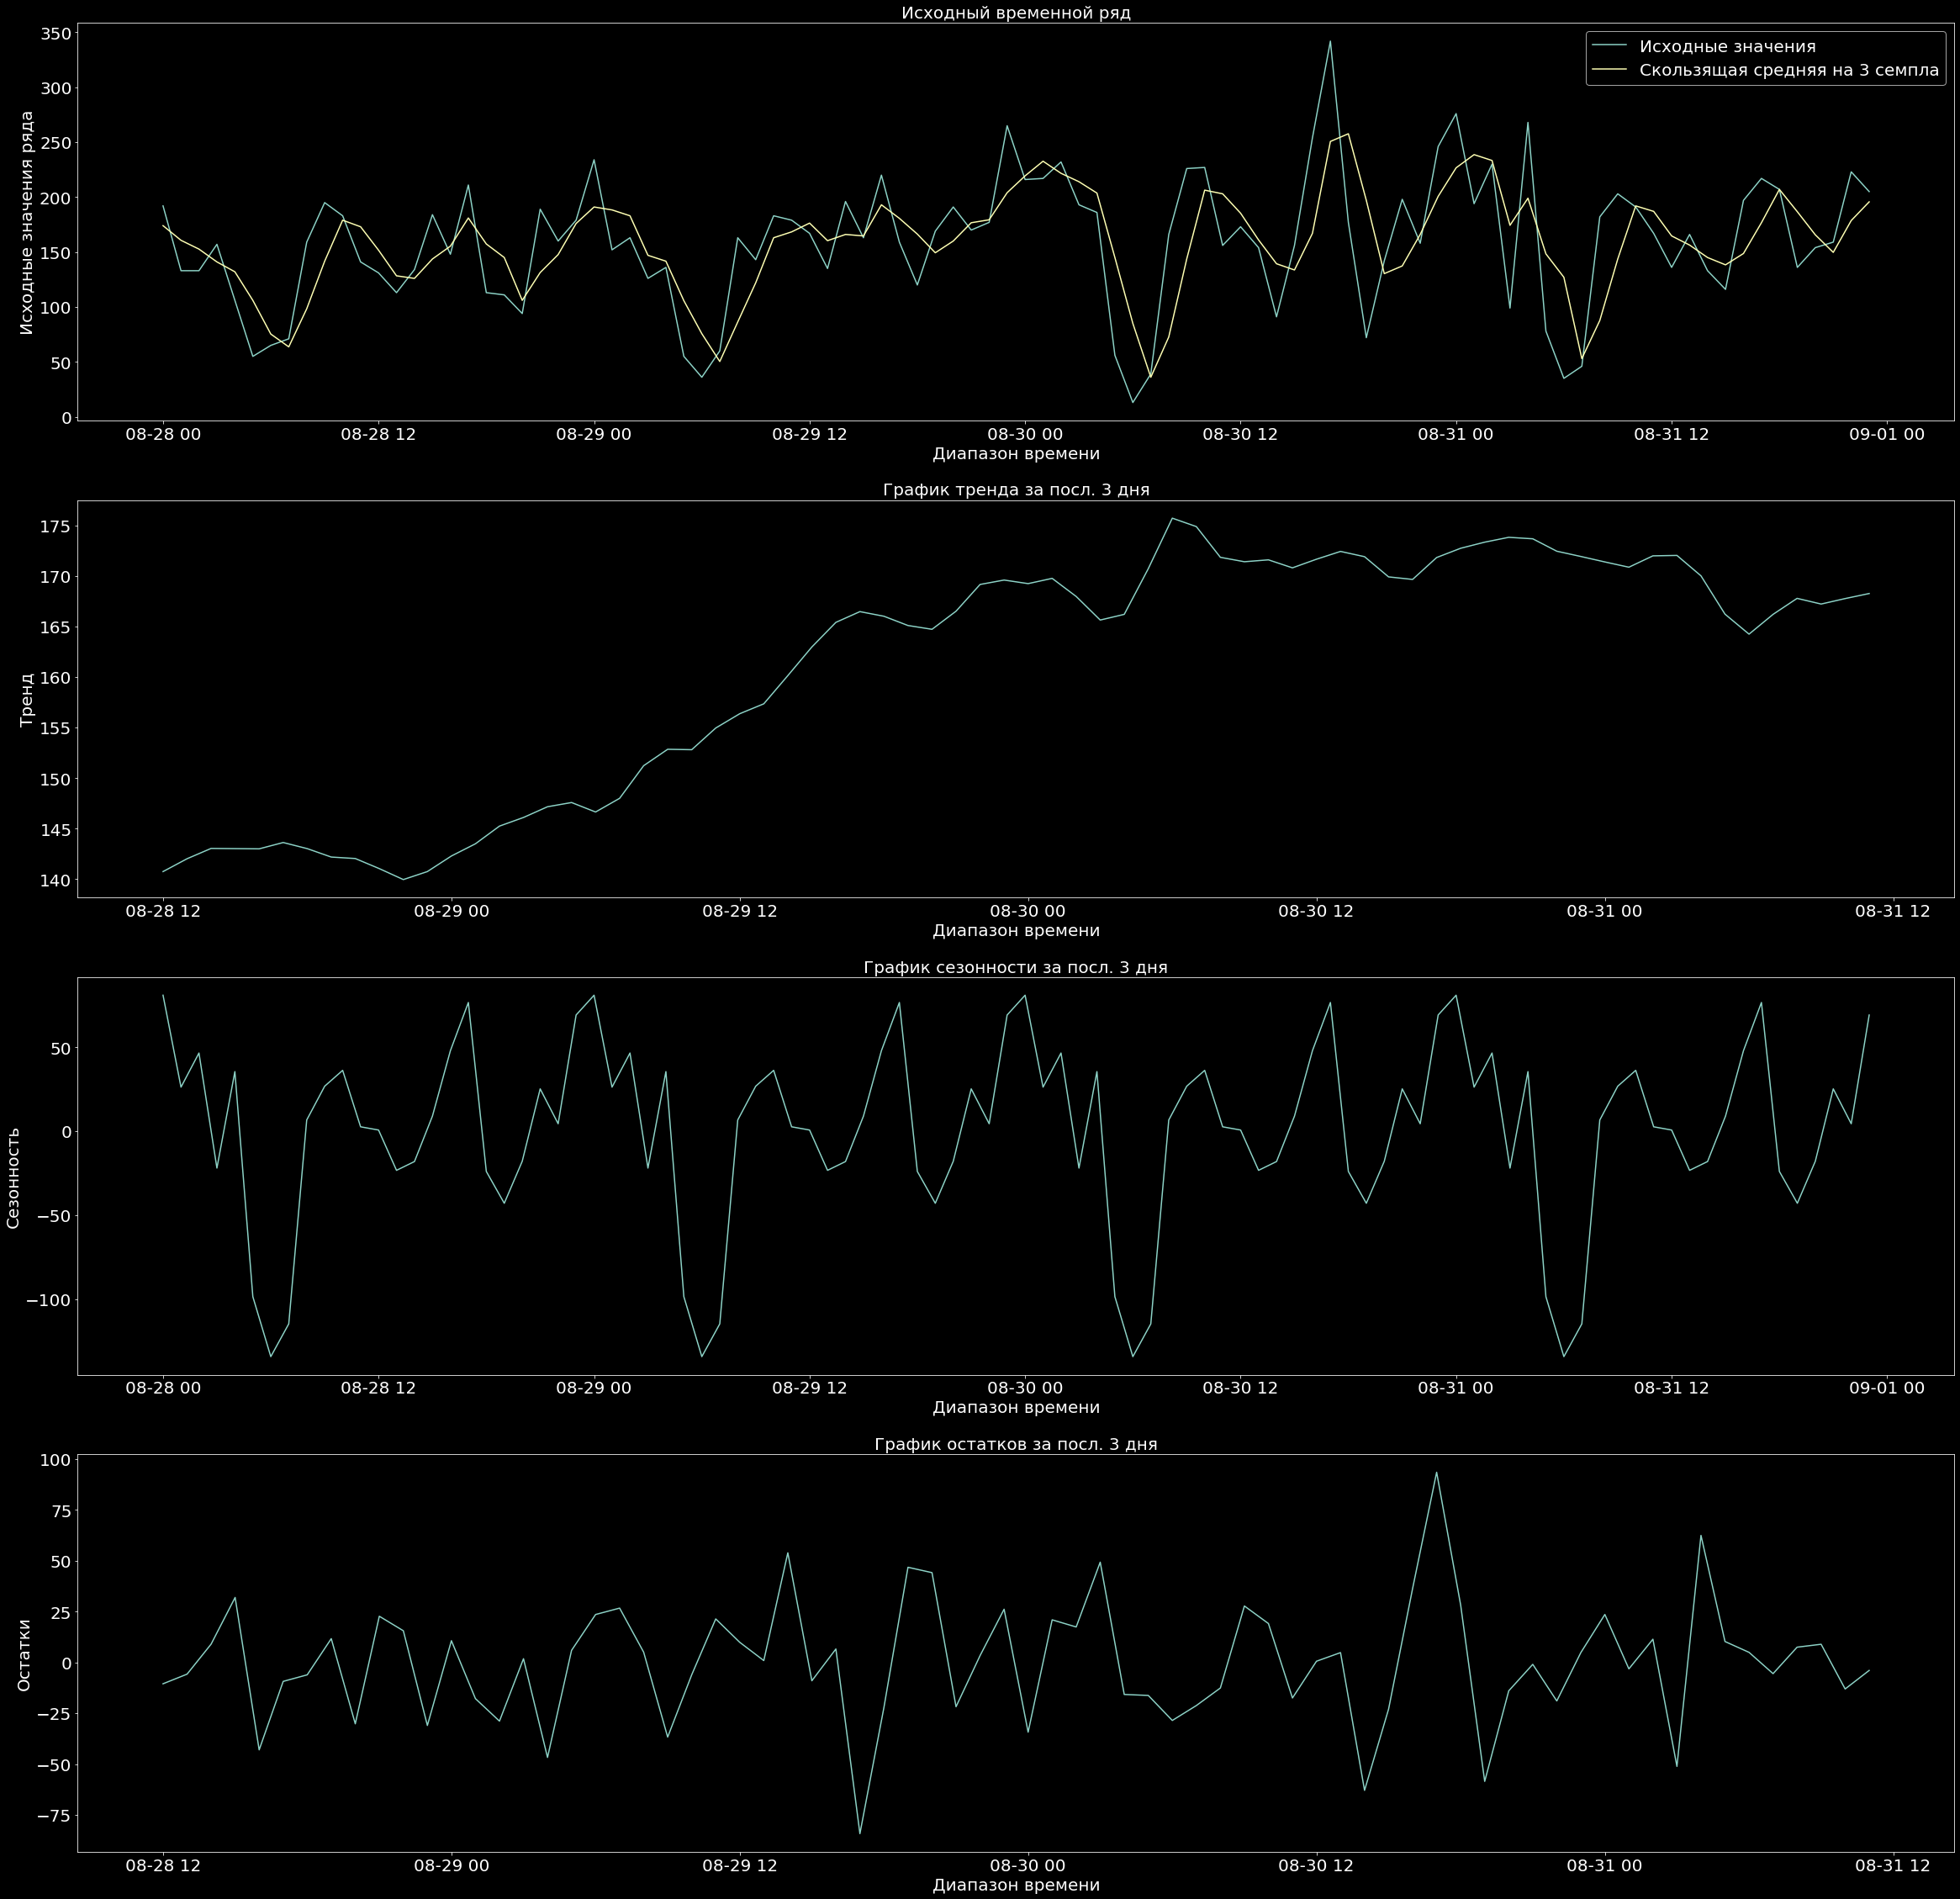

In [ ]:
df['rolling_mean'] = df['num_orders'].rolling(3).mean()

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(40, 40))

decomposed = seasonal_decompose(df['2018-08-28':'2018-08-31']['num_orders'])

ax[0].plot(df['2018-08-28':'2018-08-31'].index, decomposed.observed)
ax[0].plot(df['2018-08-28':'2018-08-31'].index, df['2018-08-28':'2018-08-31']['rolling_mean'])
ax[0].set_ylabel('Исходные значения ряда', fontsize=20)

ax[1].plot(df['2018-08-28':'2018-08-31'].index, decomposed.trend)
ax[1].set_ylabel('Тренд', fontsize=20)

ax[2].plot(df['2018-08-28':'2018-08-31'].index, decomposed.seasonal)
ax[2].set_ylabel('Сезонность', fontsize=20)

ax[3].plot(df['2018-08-28':'2018-08-31'].index, decomposed.resid)
ax[3].set_ylabel('Остатки', fontsize=20)

ax[0].tick_params(axis='y', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[2].tick_params(axis='y', labelsize=20)
ax[3].tick_params(axis='y', labelsize=20)

ax[0].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='x', labelsize=20)
ax[2].tick_params(axis='x', labelsize=20)
ax[3].tick_params(axis='x', labelsize=20)

ax[0].legend(['Исходные значения', 'Скользящая средняя на 3 семпла'], fontsize=20)
ax[0].set_title('Исходный временной ряд', fontsize=20)
ax[1].set_title('График тренда за посл. 3 дня', fontsize=20)
ax[2].set_title('График сезонности за посл. 3 дня', fontsize=20)
ax[3].set_title('График остатков за посл. 3 дня', fontsize=20)
ax[0].set_xlabel('Диапазон времени', fontsize=20)
ax[1].set_xlabel('Диапазон времени', fontsize=20)
ax[2].set_xlabel('Диапазон времени', fontsize=20)
ax[3].set_xlabel('Диапазон времени', fontsize=20)

plt.show.legend = False

Наблюдая сезонную компоненту временного ряда можно отметить что:

-количество заказов в летне-осенние сезоны больше

-в понедельник пиковые нагрузки на таксо-компанию

-в вечернее время заказов больше, ночное-утреннее до 7.00 заказов минимум (вероятно это связанно с расписанием полетов самолетов местного аэропорта)

Проверим временной ряд на стационарность тестом Дики — Фуллера. Уровень значимости возьмем 5%

In [ ]:
a = 0.01

H 0 : Временной ряд является нестационарным. Дисперсия изменяется во времени

H 1 : временной ряд является стационарным.

In [ ]:
p_val = adfuller(df['num_orders'])[1]
p_val

0.028940051402612906

In [ ]:
if p_val < a:
    print('p-value меньше уровня значимости, ряд стационарный')
else:
    print('p-value больше уровня значимости, это нам говорит о том что мы не можем отвергнуть 0-ю гипотезу и ряд является нестационарным')

p-value больше уровня значимости, это нам говорит о том что мы не можем отвергнуть 0-ю гипотезу и ряд является нестационарным


## Обучение

In [ ]:
df = df.drop('rolling_mean', axis=1)
df_raw = df.copy()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Создаем функцию для селекции признаков из временного ряда: день недели, месяц, год, день месяца, предыдущие значения ряда, скользящая средняя

In [ ]:
def make_features(data, max_lag, rollin_man):
    data_ = data.copy()
    data_['day'] = data_.index.day
    data_['day_of_week'] = data_.index.dayofweek

    for lag in range(1, max_lag + 1):
        data_['lag_{}'.format(lag)] = data_['num_orders'].shift(lag)

    data_['rolling_mean'] = data_['num_orders'].shift().rolling(rollin_man).mean()

    return data_

### Подбор ск.средней и кол-ва пред.семплов

Методом перебора найдем оптимальные значения кол-ва предыдущих значений ряда которые будем учитывать и то кол-во семплов на которые будет опираться скользящая средняя. В качестве оценки возьмем значения предсказания LinearRegression()

In [ ]:
rollin_man_iter = [i for i in range(2, 50)]
max_lag_iter = [i for i in range(5, 301)]
n_iter = 20

rollin_man_result = []
max_lag_result = []
RMSE_result = []
for _ in range(n_iter):

    rollin_man = rollin_man_iter[np.random.randint(0, len(rollin_man_iter))]
    max_lag = max_lag_iter[np.random.randint(0, len(max_lag_iter))]

    _data_ = make_features(df, max_lag, rollin_man)
    _data_ = _data_.dropna()

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_values = []

    for train_index, val_index in tscv.split(_data_):
        X_train, X_val = _data_.drop('num_orders', axis=1).iloc[train_index], _data_.drop('num_orders', axis=1).iloc[val_index]
        y_train, y_val = _data_['num_orders'].iloc[train_index], _data_['num_orders'].iloc[val_index]

        X_train = X_train[['day', 'day_of_week', 'rolling_mean']+[f'lag_{i}' for i in range(1, max_lag + 1)]]
        X_val = X_val[['day', 'day_of_week', 'rolling_mean']+[f'lag_{i}' for i in range(1, max_lag + 1)]]

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred_val = model.predict(X_val)

        rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)

        rmse_values.append(rmse_val)

    rollin_man_result.append(rollin_man)
    max_lag_result.append(max_lag)
    RMSE_result.append(np.mean(rmse_values))

    print(f'Создано признаков предыдущих значений ряда {max_lag}, Скользящая средняя ориентированна на {rollin_man} семплов')
    print("RMSE на кросс-валидации:", np.mean(rmse_values))
    print()

Создано признаков предыдущих значений ряда 82, Скользящая средняя ориентированна на 22 семплов
RMSE на кросс-валидации: 26.58536300724707

Создано признаков предыдущих значений ряда 24, Скользящая средняя ориентированна на 28 семплов
RMSE на кросс-валидации: 29.38268238628932

Создано признаков предыдущих значений ряда 13, Скользящая средняя ориентированна на 29 семплов
RMSE на кросс-валидации: 34.23036951971275

Создано признаков предыдущих значений ряда 228, Скользящая средняя ориентированна на 15 семплов
RMSE на кросс-валидации: 25.58267987283087

Создано признаков предыдущих значений ряда 143, Скользящая средняя ориентированна на 43 семплов
RMSE на кросс-валидации: 26.121635770067904

Создано признаков предыдущих значений ряда 57, Скользящая средняя ориентированна на 28 семплов
RMSE на кросс-валидации: 27.10311910010468

Создано признаков предыдущих значений ряда 183, Скользящая средняя ориентированна на 39 семплов
RMSE на кросс-валидации: 24.69227005605321

Создано признаков преды

In [ ]:
best_rmse = min(RMSE_result)
best_id = RMSE_result.index(best_rmse)
best_id

12

In [ ]:
best_make_features = []
best_make_features.append(f"RMSE обучающей выборки: {best_rmse}")
best_make_features.append(f"Создано признаков предыдущих значений ряда: {max_lag_result[best_id]}")
best_make_features.append(f"Скользящая средняя ориентированна на {rollin_man_result[best_id]} семплов")
best_make_features

['RMSE обучающей выборки: 24.353336568748354',
 'Создано признаков предыдущих значений ряда: 173',
 'Скользящая средняя ориентированна на 5 семплов']

In [ ]:
df_raw.head() # Исходный ряд

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Подготовка признаков

Выделяю из исходного ряда тестовую выборку для оценки модели

In [ ]:
df = make_features(df_raw, max_lag_result[best_id], rollin_man_result[best_id])

train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=42)
train = train.dropna()

X_train = train[['day', 'day_of_week', 'rolling_mean']
                +[f'lag_{i}' for i in range(1, max_lag_result[best_id] + 1)]]
y_train = train['num_orders']

X_test = test[['day', 'day_of_week', 'rolling_mean']
              +[f'lag_{i}' for i in range(1, max_lag_result[best_id] + 1)]]
y_test = test['num_orders']

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3801 entries, 2018-03-08 05:00:00 to 2018-08-13 13:00:00
Freq: H
Columns: 176 entries, day to lag_173
dtypes: float64(174), int64(2)
memory usage: 5.1 MB


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 176 entries, day to lag_173
dtypes: float64(174), int64(2)
memory usage: 611.2 KB


### RandomForest

Сохраняем объект TimeSeries для кросс-валидации временного ряда

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

Находим лучшие параметры RandomForestRegressor и результат ее работы на кросс-валидации:

In [ ]:
# param_grid = {
#          'min_samples_leaf': distributions.IntDistribution(1, 20),
#          'max_depth': distributions.IntDistribution(2, 300),
#          'min_samples_split': distributions.IntDistribution(2, 20),
#          'n_estimators': distributions.IntDistribution(10, 101)
#         }

# optuna_search_rf = OptunaSearchCV(
#     RandomForestRegressor(random_state=42),
#     param_grid,
#     cv=tscv,
#     n_trials=10,
#     scoring='neg_mean_squared_error',
#     random_state=42,
#     n_jobs=-1
# )

# optuna_search_rf.fit(X_train, y_train)
# print('Лучшая модель и её параметры:\n\n', optuna_search_rf.best_estimator_)
# print ('Метрика лучшей модели на кросс-валидации:', np.sqrt(optuna_search_rf.best_score_*-1))

Лучшая модель и её параметры:

 RandomForestRegressor(max_depth=96, min_samples_split=7, n_estimators=48,
                      random_state=42)
                      
Метрика лучшей модели на кросс-валидации: 24.054146357941125

### CatBoost


Нахождение параметров CatBoostRegressor:

In [ ]:
# param_grid = {
#         'learning_rate': distributions.FloatDistribution(1e-2, 1e-1),
#         'n_estimators': distributions.IntDistribution(100, 1300),
#         'max_depth': distributions.IntDistribution(2, 15)
#         }

# optuna_search_cat = OptunaSearchCV(
#     CatBoostRegressor(random_state=42),
#     param_grid,
#     cv=tscv,
#     n_trials=10,
#     scoring='neg_mean_squared_error',
#     random_state=42,
#     n_jobs=-1
# )

# optuna_search_cat.fit(X_train, y_train, verbose=False)
# print('Лучшая модель и её параметры:\n\n', optuna_search_cat.best_estimator_.get_params())
# print ('Метрика лучшей модели на кросс-валидации:', np.sqrt(optuna_search_cat.best_score_*-1))

Лучшая модель и её параметры:

 CatBoostRegressor(random_state=42, use_best_model=True, learning_rate=0.071, n_estimators=1110, max_depth=8)
                      
Метрика лучшей модели на кросс-валидации: 22.2710574513

## Тестирование

In [ ]:
cat = CatBoostRegressor(random_state=42, learning_rate=0.071, n_estimators=1110, max_depth=8)
cat.fit(X_train, y_train, verbose=False)
pred = cat.predict(X_test)
print("RMSE лучшей модели на тестовой выборки:", mean_squared_error(y_test, pred, squared=False))

RMSE лучшей модели на тестовой выборки: 38.83100407642687


Посмотрим на результат работы константной модели для относительной оценки адекватности нашей модели

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

y_test_dummy = dummy_regr.predict(X_test)

print ('Метрика Dummy модели на тестовой выборке:', mean_squared_error(y_test, y_test_dummy, squared=False))

Метрика Dummy модели на тестовой выборке: 83.98266440112194


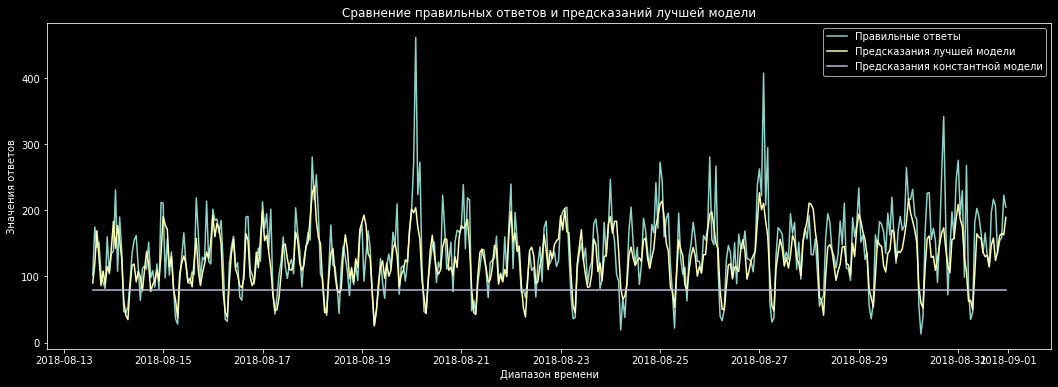

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(y_test.index, y_test, label='Правильные ответы')
plt.plot(y_test.index, pred, label='Предсказания лучшей модели')
plt.plot(y_test.index, y_test_dummy, label='Предсказания константной модели')
plt.legend()
plt.title('Сравнение правильных ответов и предсказаний лучшей модели')
plt.xlabel('Диапазон времени')
plt.ylabel('Значения ответов')
plt.show()

Модель демонстрирует наибольшую ошибку в предсказаниях загруженности в понедельник, а также не полностью улавливает недельную сезонность. Кроме того, модель имеет тенденцию к усреднению результатов, что может указывать на недостаточную способность к обучению и адаптации к конкретным закономерностям в данных.

### Вывод

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными:

<h4>Подготовка</h4>

Данные представленны в виде временного ряда:

В таблице 26496 наблюдений на диапазоне времени '2018-03-01 00:00:00' - '2018-08-31 23:50:00', кол-во заказов представленно в int64 типе данных

Пропусков и явных дубликатов в данных нет

Проведенно ресемплирование ряда по одному часу

<h4>Анализ</h4>

Ряд выглядит слегка не стационарно, виднеются повышения ср.значения и дисперсии со временем

Значения ряда варьируются от 0 до 462, в среднем 84.4, стандартное отклонение - 45

Ряд напоминает нормальное распределение со 'скосом' к левому краю, значения находящиеся в правой части распределения слегка выбиваются из общей массы

Тренд ряда восходящий

При приближении ряда, моментами стали более остро видны выбивающиеся значения, которые циклируются каждую неделю

<h4>Обучение</h4>

Найдены оптимальные значения кол-ва предыдущих значений ряда и то кол-во семплов на которые будет опираться скользящая средняя

Найдены лучшие параметры RandomForestRegressor(max_depth=96, min_samples_split=7, n_estimators=48, random_state=42)

Метрика лучшей модели на кросс-валидации: 24.054146357941125

Найдены лучшие параметры CatBoostRegressor(random_state=42, use_best_model=True, learning_rate=0.071, n_estimators=1110, max_depth=8)

Метрика лучшей модели на кросс-валидации: 22.2710574513

<h4>Тестирование</h4>

Получены результаты лучшей модели на тесте

RMSE CatBoostRegressor на тестовой выборки: 44.4196146702417




